In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)
import seaborn as sns

from datetime import datetime, timedelta

from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')


# basic number of currencies we will be working with
x = 10

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('crypto-markets.csv', parse_dates=['date'], index_col='date', date_parser=dateparse)
df.head(x)

,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,,,,,,,,,,,,
2013-04-28,bitcoin,BTC,Bitcoin,1,135.30,135.98,132.10,134.21,0,1500520000,0.5438,3.88
2013-04-29,bitcoin,BTC,Bitcoin,1,134.44,147.49,134.00,144.54,0,1491160000,0.7813,13.49
2013-04-30,bitcoin,BTC,Bitcoin,1,144.00,146.93,134.05,139.00,0,1597780000,0.3843,12.88
2013-05-01,bitcoin,BTC,Bitcoin,1,139.00,139.89,107.72,116.99,0,1542820000,0.2882,32.17
2013-05-02,bitcoin,BTC,Bitcoin,1,116.38,125.60,92.28,105.21,0,1292190000,0.3881,33.32
2013-05-03,bitcoin,BTC,Bitcoin,1,106.25,108.13,79.10,97.75,0,1180070000,0.6424,29.03
2013-05-04,bitcoin,BTC,Bitcoin,1,98.10,115.00,92.50,112.50,0,1089890000,0.8889,22.50
2013-05-05,bitcoin,BTC,Bitcoin,1,112.90,118.80,107.14,115.91,0,1254760000,0.7521,11.66
2013-05-06,bitcoin,BTC,Bitcoin,1,115.98,124.66,106.64,112.30,0,1289470000,0.3141,18.02


In [3]:
# Extract the bitcoin data only
# Get the bitcoin data, rank 1, most information present
btc=df[df['symbol']=='BTC']
# Drop some columns
btc.drop(['slug', 'volume','symbol','name','ranknow','market', 'close_ratio', 'spread'],axis=1,inplace=True)

In [4]:
# Resampling to monthly frequency
btc_month = btc.resample('M').mean()

In [5]:
btc_month.head()

,open,high,low,close
date,,,,
2013-04-30,137.913333,143.466667,133.383333,139.250000
2013-05-31,120.292258,123.949032,114.253548,119.993226
2013-06-30,108.856333,111.300667,104.602333,107.761333
2013-07-31,90.311613,93.869032,86.719355,90.512258
2013-08-31,113.041935,116.002258,111.388065,113.905161


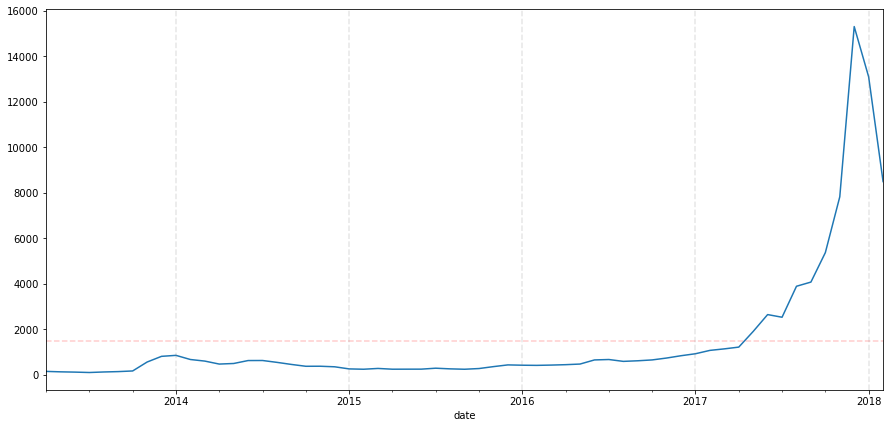

In [6]:
btc_month.close.plot()
plt.axhline(btc_month.close.mean(), color='r', alpha=0.2, linestyle='--')

for year in range(2014, 2019):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='gray', alpha=0.2, linestyle='--')

#### Quite unusual trend, as initially it was nearly mediating through the mean line, but again it started surging at the end of 2017

Dickey–Fuller test: p=0.998803
weak evidence aginst null hypothesis, time series has a unit root, the data is non stationary


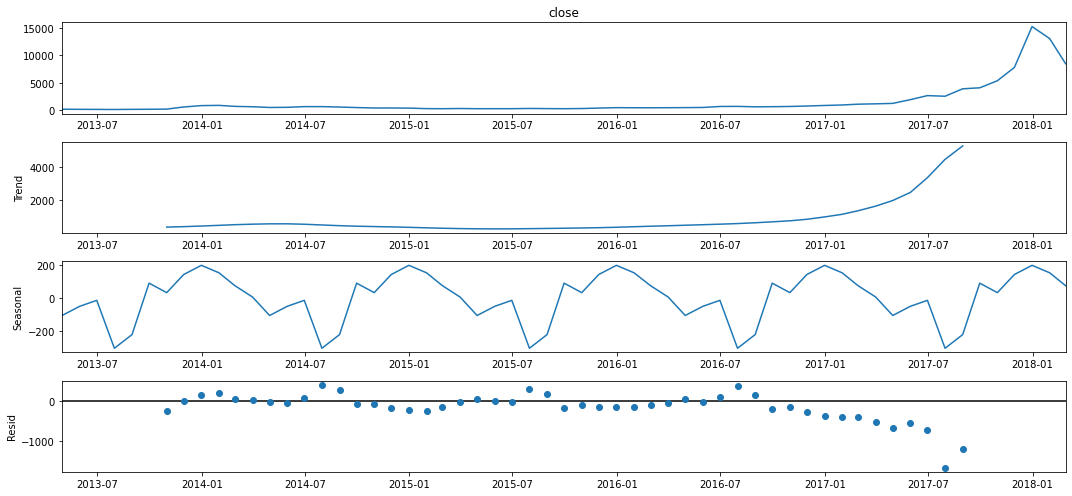

In [7]:
seasonal_decompose(btc_month.close).plot()


print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close)[1])


if(adfuller(btc_month.close)[1] <= 0.05):
    print("strong evidence aginst null hypothesis, the data is stationary")
else:
    print("weak evidence aginst null hypothesis, time series has a unit root, the data is non stationary")
plt.show()

In [8]:
# Box-Cox Transformations
btc_month['close_box'], lmbda = stats.boxcox(btc_month.close)


print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close_box)[1])


if(adfuller(btc_month.close_box)[1] <= 0.05):
    print("strong evidence aginst null hypothesis, the data is stationary")
else:
    print("weak evidence aginst null hypothesis, time series has a unit root, the data is non stationary")

Dickey–Fuller test: p=0.494475
weak evidence aginst null hypothesis, time series has a unit root, the data is non stationary


In [9]:
# Seasonal differentiation (12 months)
btc_month['box_diff_seasonal_12'] = btc_month.close_box - btc_month.close_box.shift(12)


print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])


if(adfuller(btc_month.box_diff_seasonal_12[12:])[1] <= 0.05):
    print("strong evidence aginst null hypothesis, the data is stationary")
else:
    print("weak evidence aginst null hypothesis, time series has a unit root, the data is non stationary")

Dickey–Fuller test: p=0.661446
weak evidence aginst null hypothesis, time series has a unit root, the data is non stationary


In [10]:
btc_month['box_diff_seasonal_3'] = btc_month.close_box - btc_month.close_box.shift(3)


print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])


if(adfuller(btc_month.box_diff_seasonal_3[3:])[1] < 0.05):
    print("strong evidence aginst null hypothesis, the data is stationary")
else:
    print("weak evidence aginst null hypothesis, time series has a unit root, the data is non stationary")

Dickey–Fuller test: p=0.018033
strong evidence aginst null hypothesis, the data is stationary


Dickey–Fuller test: p=0.002424
strong evidence aginst null hypothesis, the data is stationary


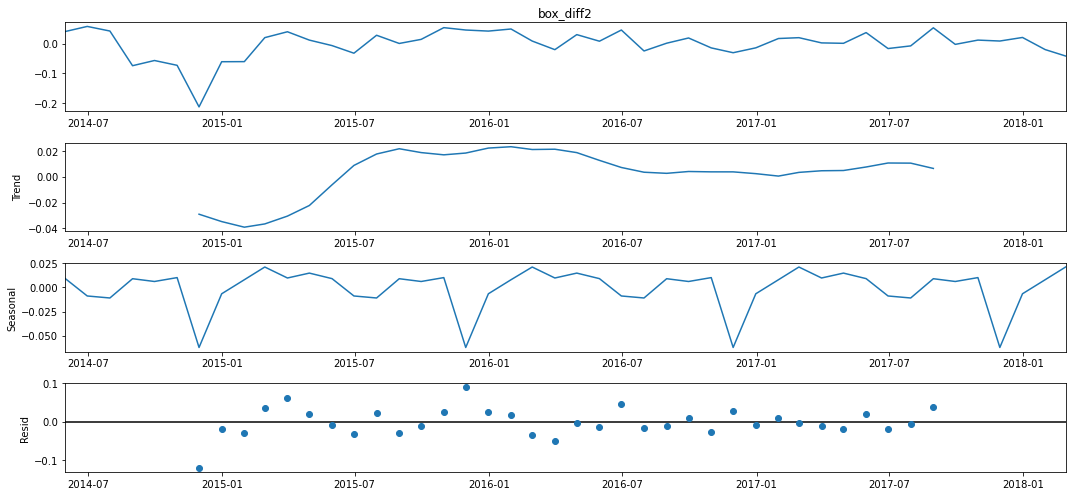

In [11]:
# Regular differentiation
btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(btc_month.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff2[13:])[1])

if(adfuller(btc_month.box_diff2[13:])[1] < 0.05):
    print("strong evidence aginst null hypothesis, the data is stationary")
else:
    print("weak evidence aginst null hypothesis, time series has a unit root, the data is non stationary")

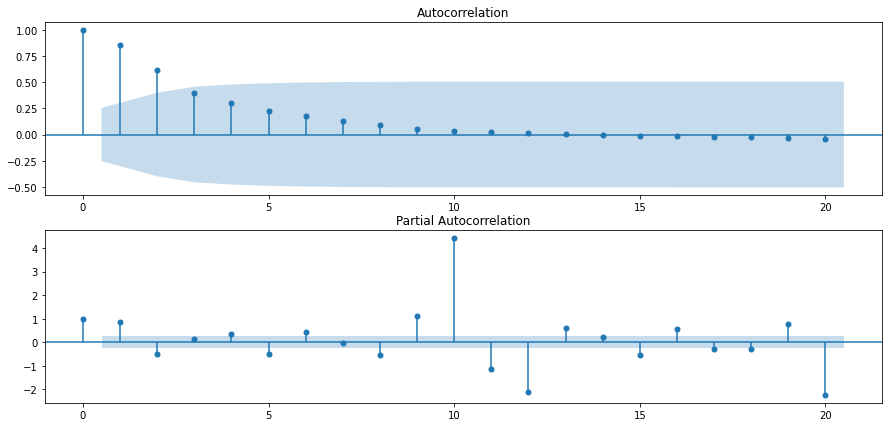

In [12]:
ax = plt.subplot(211)
plot_acf(btc_month.close, lags=20, ax=ax)


ax = plt.subplot(212)
plot_pacf(btc_month.close, lags=20, ax=ax)
plt.show()

#### The auto correlation graph is decreasing exponentially, and thus can be said quite well corelated data. 

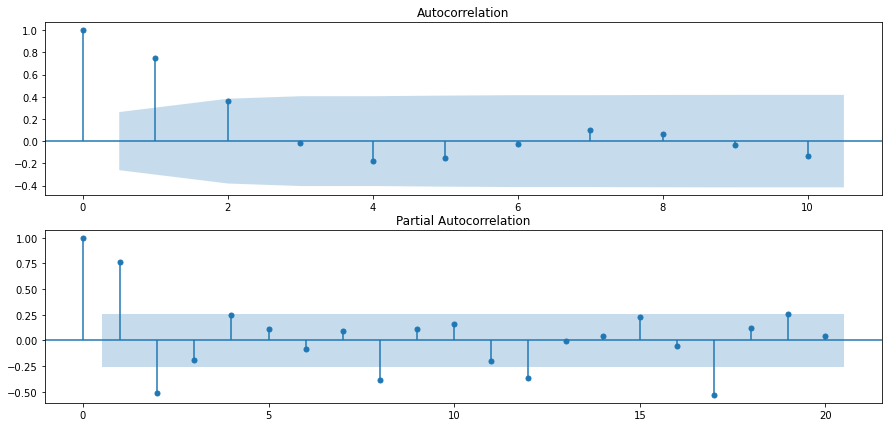

In [13]:
ax = plt.subplot(211)
plot_acf(btc_month.box_diff_seasonal_3[3:], lags=10, ax=ax)


ax = plt.subplot(212)
plot_pacf(btc_month.box_diff_seasonal_3[3:], lags=20, ax=ax)
plt.show()

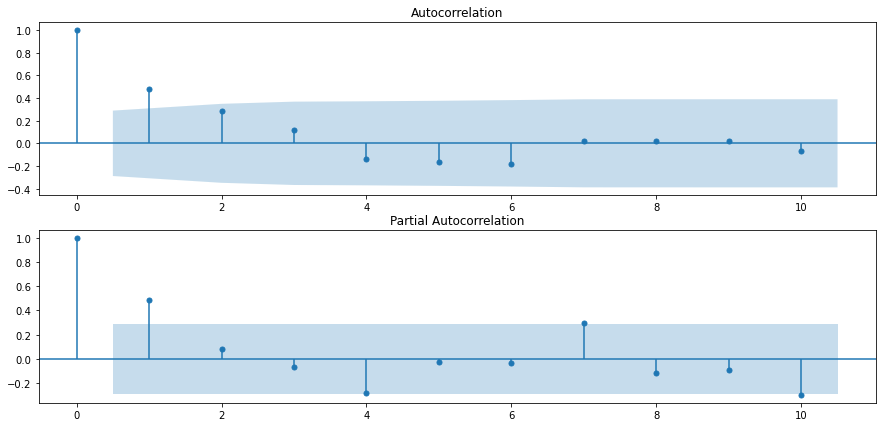

In [14]:
ax = plt.subplot(211)
plot_acf(btc_month.box_diff2[13:], lags=10, ax=ax)

ax = plt.subplot(212)
plot_pacf(btc_month.box_diff2[13:], lags=10, ax=ax)
plt.show()

## ARIMA model : Auto Regressive Integrated Moving Averages model

#### AR value : p 
#### MA value : q
#### Degree of differencing : d


In [15]:
# Initail approximation of the parameters
ps = range(0,3)
qs = range(0,3)
d = 1

parameters_list = list(product(ps,qs))

len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
for param in parameters_list:
    model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [16]:
print(results, best_param)

[[(0, 0), -213.45478970250863], [(0, 1), -219.76532796509886], [(0, 2), -217.95425535419938], [(1, 0), -220.1135847333209], [(1, 1), -218.16400076450032], [(1, 2), -216.21372024146496], [(2, 0), -218.15206449111565], [(2, 1), -216.6956529129748], [(2, 2), -214.6400825529647]] (1, 0)


In [17]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              close_box   No. Observations:                   59
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 112.057
Date:                Sat, 29 Jan 2022   AIC                           -220.114
Time:                        12:54:35   BIC                           -215.993
Sample:                    04-30-2013   HQIC                          -218.508
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3743      0.152      2.470      0.014       0.077       0.671
sigma2         0.0012      0.000     11.215      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               546.73
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                             2.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
3     (1, 0) -220.113585
1     (0, 1) -219.765328
4     (1, 1) -218.164001
6     (2, 0) -218.152064
2     (0, 2) -217.954255


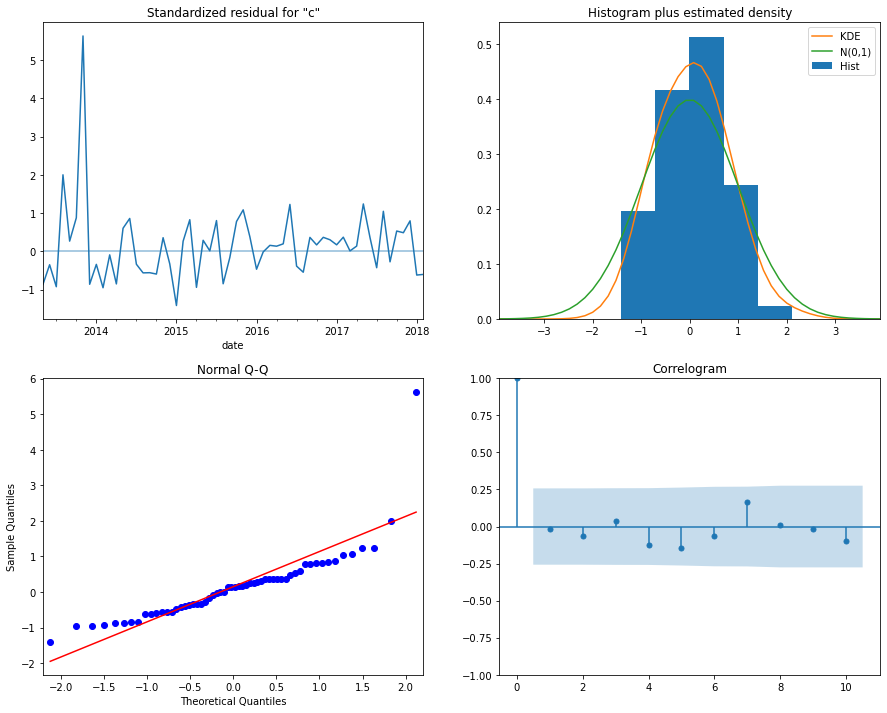

In [19]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.


In the histogram (top right), the KDE line should follow the N(0,1) line (normal distribution with mean 0, standard deviation 1) closely. This is an indication whether the residuals are normally distributed or not.

In the Q-Q-plot the ordered distribution of residuals (blue dots) should follow the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is an indication whether the residuals are normally distributed.

The standardized residual plot doesn't display any obvious seasonality. 
This is confirmed by the autocorrelation plot, which shows that the time series residuals have low correlation with lagged versions of itself.

## Prediction

In [20]:
def invboxcox(y, lmbda):
    if(lmbda==0):
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y+1)/lmbda)

In [21]:
prediction_data = btc_month[['close']]

In [22]:
date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
future = pd.DataFrame(index=date_list, columns=['close'])

prediction_data = pd.concat([prediction_data, future])

In [23]:
prediction_data

,close
2013-04-30,139.250000
2013-05-31,119.993226
2013-06-30,107.761333
2013-07-31,90.512258
2013-08-31,113.905161
...,...
2018-02-28,8481.696000
2018-03-31,NaN
2018-04-30,NaN
2018-05-31,NaN


In [24]:
prediction_values = invboxcox(best_model.predict(start=datetime(2013,4,30), end=datetime(2018,6,30)), lmbda)
prediction_data['pred_close'] = prediction_values

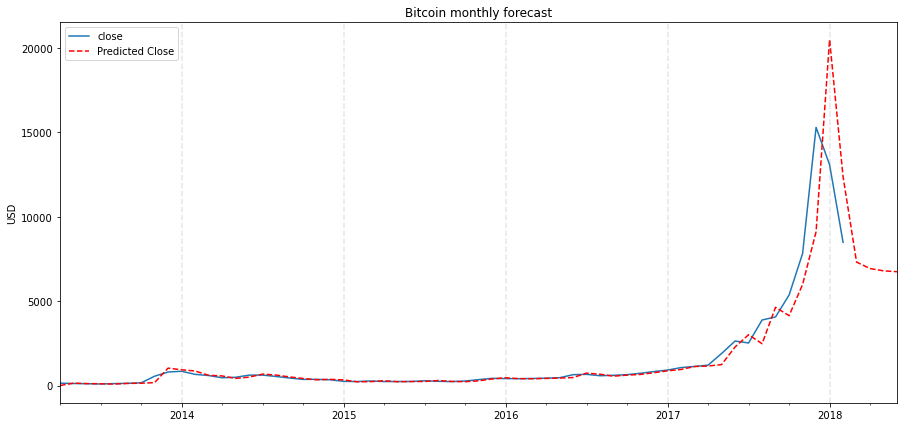

In [25]:
plt.figure(figsize=(15,7))
prediction_data.close.plot()
prediction_data.pred_close.plot(color='r', ls='--', label='Predicted Close')
for year in range(2014,2019):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='gray',alpha=0.2, ls='--')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()

In [26]:
y_forcasted = prediction_data[datetime(2013,8,31):datetime(2018,2,28)].pred_close
y_truth = prediction_data[datetime(2013,8,31):datetime(2018,2,28)].close

rmse = np.sqrt(((y_forcasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 6)))

Mean Squared Error: 1455.934514


## SARIMAX model

In [27]:
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters_list = list(product(ps, qs, Ps, Qs))

In [28]:
results = []
best_aic = float("inf")
for param in parameters_list:
    model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [29]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
21  (1, 0, 1, 1) -193.013122
49  (2, 2, 0, 1) -192.919337
19  (1, 0, 0, 1) -192.627054
7   (0, 1, 0, 1) -192.226372
9   (0, 1, 1, 1) -192.174973
                                      SARIMAX Results                                      
Dep. Variable:                           close_box   No. Observations:                   59
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 4)   Log Likelihood                 100.507
Date:                             Sat, 29 Jan 2022   AIC                           -193.013
Time:                                     12:55:04   BIC                           -185.057
Sample:                                 04-30-2013   HQIC                          -189.945
                                      - 02-28-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

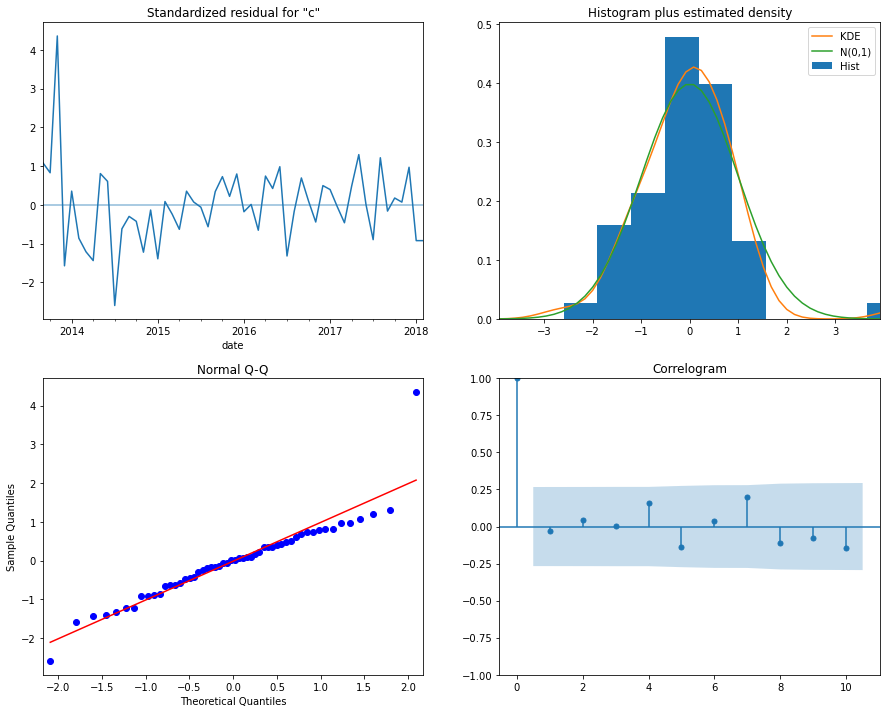

In [30]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

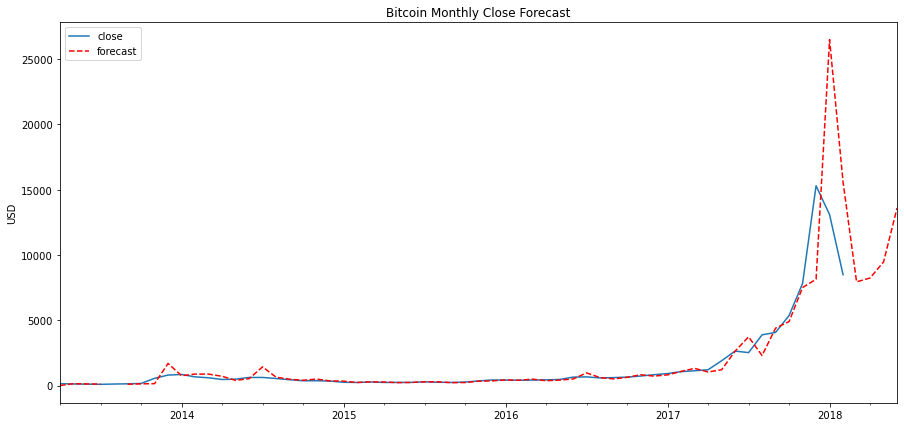

In [31]:
btc_month2 = btc_month[['close']]
date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month2 = pd.concat([btc_month2, future])

btc_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)

plt.figure(figsize=(15,7))
btc_month2.close.plot()
btc_month2.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title('Bitcoin Monthly Close Forecast')
plt.ylabel('USD')
plt.savefig('bitcoin_monthly_forecast.png')
plt.show()

In [32]:
y_forecasted = btc_month2.forecast
y_truth = btc_month2['2015-01-01':'2017-01-01'].close

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))


Mean Squared Error: 85.24


In [33]:
ps = range(0,3)
qs = range(0,3)
d = 1

parameters_list = list(product(ps,qs))

len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
for param in parameters_list:
    model = SARIMAX(btc_month.box_diff2, order=(param[0], d, param[1])).fit(disp=-1)
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [34]:
print(results, best_param)

[[(0, 0), -129.21115695595802], [(0, 1), -132.69348024927936], [(0, 2), -131.41488536547362], [(1, 0), -132.1812191930414], [(1, 1), -135.03437595365736], [(1, 2), -129.80798929723926], [(2, 0), -130.8258222841556], [(2, 1), -130.65090543787593], [(2, 2), -131.46995989440492]] (1, 1)


In [35]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              box_diff2   No. Observations:                   59
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  70.517
Date:                Sat, 29 Jan 2022   AIC                           -135.034
Time:                        12:56:04   BIC                           -128.853
Sample:                    04-30-2013   HQIC                          -132.627
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5180      0.132      3.916      0.000       0.259       0.777
ma.L1         -0.9991      7.041     -0.142      0.887     -14.800      12.801
sigma2         0.0017      0.012      0.143      0.886      -0.022       0.025
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               100.89
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                            -1.54
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
btc_pred = btc_month[['close', 'box_diff2']]

In [37]:
date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
future = pd.DataFrame(index=date_list, columns=['close', 'box_diff2'])

btc_pred = pd.concat([btc_pred, future])

In [44]:
btc_pred.tail(10)

,close,box_diff2,pred_box_diff2
2017-09-30,4064.836333,-0.002559,0.028357
2017-10-31,5360.071613,0.011732,-0.001090
2017-11-30,7813.133000,0.008615,0.006604
2017-12-31,15294.270968,0.020551,0.005033
2018-01-31,13085.558065,-0.019992,0.011553
2018-02-28,8481.696000,-0.041558,-0.010118
2018-03-31,NaN,NaN,-0.021944
2018-04-30,NaN,NaN,-0.011783
2018-05-31,NaN,NaN,-0.006520
2018-06-30,NaN,NaN,-0.003793


In [43]:
btc_pred['pred_box_diff2'] = best_model.predict(start=datetime(2014,4,30), end=datetime(2018,6,30))

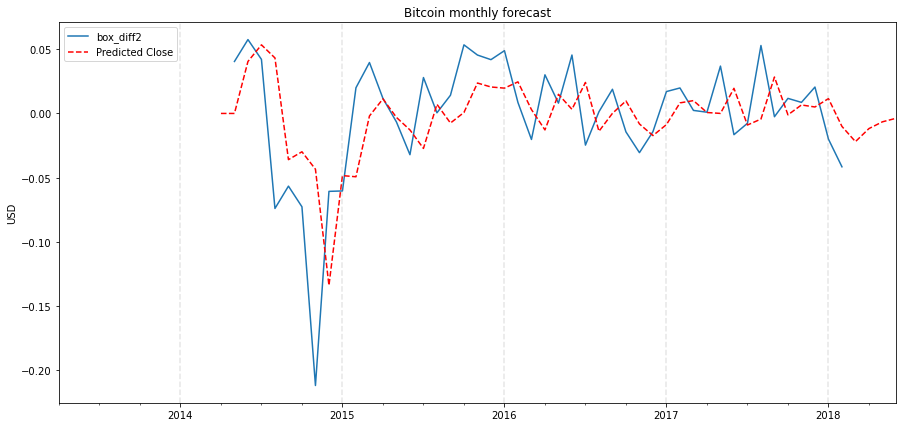

In [45]:
plt.figure(figsize=(15,7))
btc_pred.box_diff2.plot()
btc_pred.pred_box_diff2.plot(color='r', ls='--', label='Predicted Close')
for year in range(2014,2019):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='gray',alpha=0.2, ls='--')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()

In [49]:
btc_pred['pred_close'] = best_model.predict(start=datetime(2014,4,30), end=datetime(2018,6,30)) + btc_pred['close']

In [54]:
btc_pred['pred_close'] = btc_month2['forecast']
# btc_month2

In [56]:
btc_pred['predicted_close'] = btc_pred['pred_close'] + btc_pred['pred_box_diff2']

In [57]:
btc_pred

,close,box_diff2,pred_box_diff2,pred_close,predicted_close
2013-04-30,139.250000,NaN,NaN,1.000000,NaN
2013-05-31,119.993226,NaN,NaN,139.250001,NaN
2013-06-30,107.761333,NaN,NaN,119.993226,NaN
2013-07-31,90.512258,NaN,NaN,107.761333,NaN
2013-08-31,113.905161,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2018-02-28,8481.696000,-0.041558,-0.010118,15566.317096,15566.306977
2018-03-31,NaN,NaN,-0.021944,7935.838600,7935.816657
2018-04-30,NaN,NaN,-0.011783,8232.027011,8232.015228
2018-05-31,NaN,NaN,-0.006520,9463.879447,9463.872927


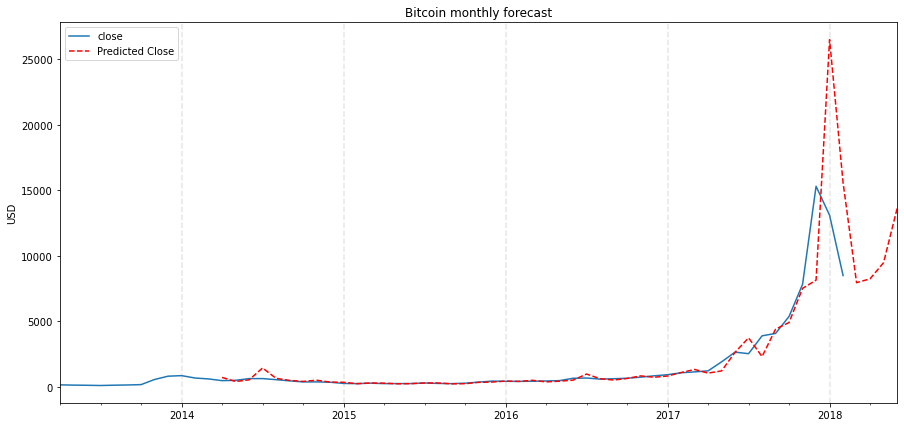

In [58]:
plt.figure(figsize=(15,7))
btc_pred.close.plot()
btc_pred.predicted_close.plot(color='r', ls='--', label='Predicted Close')
for year in range(2014,2019):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='gray',alpha=0.2, ls='--')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()